In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

'''
----------------------------------GUIDE----------------------------------

from IIR2Filter import IIR2Filter
MyFilter = IIR2Filter(order,cutoff,filterType,design='butter',rp=1,rs=1,fs=0)
    
At the instantiation of the filter the following parameters are compulsory:
    order:positive integer
        It represents the order of the desired filter.
        Can be odd or even number, the filter will create a chain of second
        order filters and an extra first order one if necessary.
    cutoff:array/positive float
        Depending on the desired filter 1 cutoff frequency is to be 
        enetered as a positive float for low/highpass filters or
        2 cutoff frequenices to be entered in an array as positive floats
        for bandstop and bandpass filters. These cutoff frequencies can be
        either entered as normalised to the Nyquist frequency (1 =
        Nyquist frequency) or as Hz (0 < f < Nyquist), but in this case fs,
        the sampling frequency has to be passed too.
    filterType:string
        Options are: lowpass, highpass, bandpass, bandstop
            
The following paremeters are NON-compulsory:
    design:string
        Different types of coefficient generations
        can be chosen. The three available filters are Butterworth, 
        Chebyshev type 1 or type 2.
        The options are: butter, cheby1, cheby2. If left unspecified the 
        default value is butter.
    rp:positive float    
        Only necessary if cheby1 is chosen to be used. It defines the 
        maximum allowed passband ripples in decibels. If unspecified the
        default is 1.
    rs:positive float    
        Only necessary if cheby2 is chosen to be used. It defines the 
        minimum required stopband attenuation in decibels. If unspecified 
        the default is 1.
    fs:positive float
        The sampling frequency should only be specified if the cutoff 
        frequency(es) provided are not normalised to Nyquist already. 
        In that case the sampling frequency in Hz will be used to normalise 
        them.
            
            
Example:
    
from IIR2Filter import IIR2Filter
FilterMains = IIR2Filter(10,[45,55],'bandstop',design='cheby1',rp=2,fs=1000)
    
for i in range(len(mySignal)):
    mySignalFiltered[i] = FilterMains.filter(mySignal[i])
        
# It creates a 10th order Chebyshev type 1 bandstop filter where the cutoff
# frequencies are at 45 and 55Hz for digital signals sampled at 1000Hz. 
# The filter allows a maximum of 2 dB passband ripples. The signal is then
# filtered sample by sample and stored in the mySignalFiltered array. 
---------------------------------------------------------------------------                   
'''    

import numpy as np
import scipy.signal as signal

class IIR2Filter(object):           
    
    def createCoeffs(self,order,cutoff,filterType,design='butter',rp=1,rs=1,fs=0):
        
        #defining the acceptable inputs for the design and filterType params
        self.designs = ['butter','cheby1','cheby2']
        self.filterTypes1 = ['lowpass','highpass','Lowpass','Highpass','low','high']
        self.filterTypes2 = ['bandstop','bandpass','Bandstop','Bandpass']
        
        #Error handling: other errors can arise too, but those are dealt with 
        #in the signal package.
        self.isThereAnError = 1 #if there was no error then it will be set to 0
        self.COEFFS = [0] #with no error this will hold the coefficients
        
        if design not in self.designs:
            print('Gave wrong filter design! Remember: butter, cheby1, cheby2.')
        elif filterType not in self.filterTypes1 and filterType not in self.filterTypes2:
            print('Gave wrong filter type! Remember: lowpass, highpass', 
                  ', bandpass, bandstop.')
        elif fs < 0:
            print('The sampling frequency has to be positive!')
        else:
            self.isThereAnError = 0
        
        #if fs was given then the given cutoffs need to be normalised to Nyquist
        if fs and self.isThereAnError == 0:
            for i in range(len(cutoff)):
                cutoff[i] = cutoff[i]/fs*2
        
        if design == 'butter' and self.isThereAnError == 0:
            self.COEFFS = signal.butter(order,cutoff,filterType,output='sos')
        elif design == 'cheby1' and self.isThereAnError == 0:
            self.COEFFS = signal.cheby1(order,rp,cutoff,filterType,output='sos')
        elif design == 'cheby2' and self.isThereAnError == 0:
            self.COEFFS = signal.cheby2(order,rs,cutoff,filterType,output='sos')
        
        return self.COEFFS
        
    def __init__(self,order,cutoff,filterType,design='butter',rp=1,rs=1,fs=0):
        self.COEFFS = self.createCoeffs(order,cutoff,filterType,design,rp,rs,fs)
        self.acc_input = np.zeros(len(self.COEFFS))
        self.acc_output = np.zeros(len(self.COEFFS))
        self.buffer1 = np.zeros(len(self.COEFFS))
        self.buffer2 = np.zeros(len(self.COEFFS))
        self.input = 0
        self.output = 0

        
        
    def filter(self,input):

        #len(COEFFS[0,:] == 1 means that there was an error in the generation 
        #of the coefficients and the filtering should not be used
        if len(self.COEFFS[0,:]) > 1:
        
            self.input = input
            self.output = 0
            
            #The for loop creates a chain of second order filters according to 
            #the order desired. If a 10th order filter is to be created the 
            #loop will iterate 5 times to create a chain of 5 second order 
            #filters.
            for i in range(len(self.COEFFS)):
                
                
                self.FIRCOEFFS = self.COEFFS[i][0:3]
                self.IIRCOEFFS = self.COEFFS[i][3:6]
                
                #Calculating the accumulated input consisting of the input and 
                #the values coming from the feedbaack loops (delay buffers 
                #weighed by the IIR coefficients).
                self.acc_input[i] = (self.input + self.buffer1[i] 
                * -self.IIRCOEFFS[1] + self.buffer2[i] * -self.IIRCOEFFS[2])
                    
                #Calculating the accumulated output provided by the accumulated
                #input and the values from the delay bufferes weighed by the 
                #FIR coefficients.
                self.acc_output[i] = (self.acc_input[i] * self.FIRCOEFFS[0]
                + self.buffer1[i] * self.FIRCOEFFS[1] + self.buffer2[i] 
                * self.FIRCOEFFS[2])
                
                #Shifting the values on the delay line: acc_input->buffer1->
                #buffer2
                self.buffer2[i] = self.buffer1[i]
                self.buffer1[i] = self.acc_input[i]
                
                self.input = self.acc_output[i]
            
            self.output = self.acc_output[i]
                
        return self.output
    

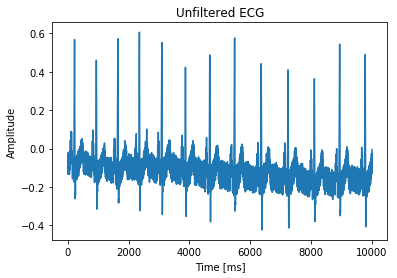

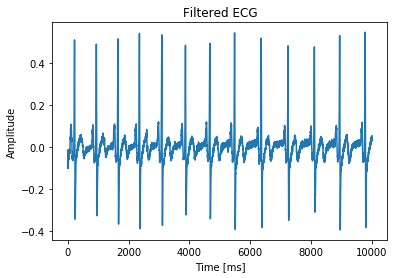

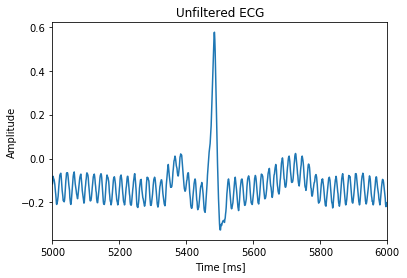

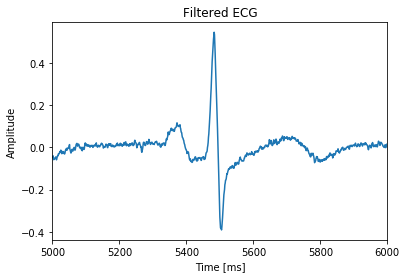

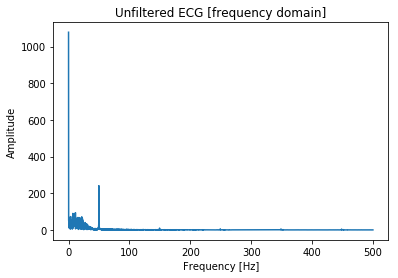

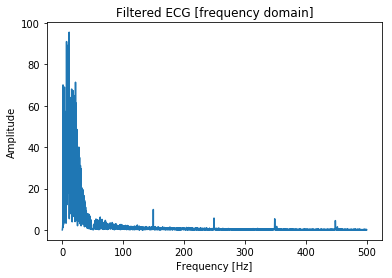

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan  6 20:38:44 2018

@author: gergo
"""


import matplotlib.pyplot as plt
import numpy as np
# from IIR2Filter import IIR2Filter

#----------Importing and preparing the signal before filtering-----------
data = np.loadtxt('resting.dat')
ampGain = 500;
fs = 1000;

ecg = data[:,1]
x = data[:,0]

# reducing the signal to remove amplifier gain 
ecg = ecg/ampGain #ecg amplitude in mVs
rangeEcg = max(ecg)-min(ecg)
ecg = ecg-(min(ecg)+rangeEcg/2)

ecg = ecg[0:10000]
x = x[0:10000]

#---------------------------------Filtering-----------------------------

# Frequencies are given as Hz, hence they need to be normalised (fs required)
FilterMains = IIR2Filter(3,[45,55],'bandstop',design='cheby1',rp=0.01,fs=fs)
# Creates a 10th order highpass Butterworth filter with normalised cutoff 
# frequency 0.002 (=1 Hz with a 1000 Hz sampling frequency).
FilterDC = IIR2Filter(4,0.002,'highpass')

ecgFiltered = np.zeros(len(ecg))

for i in range(len(ecg)):
    ecgFiltered[i] = FilterMains.filter(ecg[i])
    ecgFiltered[i] = FilterDC.filter(ecgFiltered[i])
        
#-------------------------------Plotting---------------------------------    

plt.figure(1)
plt.plot(x,ecg)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Unfiltered ECG")

plt.figure(2)
plt.plot(x,ecgFiltered)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Filtered ECG")

plt.figure(3)
plt.plot(x[5000:6000],ecg[5000:6000])
plt.xlim([5000,6000])
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Unfiltered ECG")

plt.figure(4)
plt.plot(x[5000:6000],ecgFiltered[5000:6000])
plt.xlim([5000,6000])
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Filtered ECG")

freq = np.fft.fft(ecg)
freq = abs(freq[0:int(len(freq)/2)])
xfF = np.linspace(0,fs/2,len(freq))
plt.figure(5)
plt.plot(xfF,np.real(freq))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("Unfiltered ECG [frequency domain]")

freq = np.fft.fft(ecgFiltered)
freq = abs(freq[0:int(len(freq)/2)])
xfF = np.linspace(0,fs/2,len(freq))
plt.figure(6)
plt.plot(xfF,np.real(freq))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("Filtered ECG [frequency domain]")

plt.show()